In [1]:
import os
import tempfile
import numpy as np
import xarray as xr
from eocene_creator import EoceneOIFS
from cdo import Cdo
cdo = Cdo()
#cdo.debug = False   # evita imprimir stderr/stdout
#cdo.returnNoneOnError = True  # devuelve None en lugar de tirar error

# Modificando oceanos

In [2]:
# ===============================
# 1. Cargar y remapear datos
# ===============================
icmcl_file = "/home/ecme3497/hpcperm/ece4-database/oifs/TL63L31/climate.v020/ICMCLECE4"
icmcl_remap_path = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc"
icmcl_lowres_path = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap_lowres.nc"
output_file = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_eoc_deepmip_v2.nc"

resolution = "TL63"
gaussian = 48

if os.path.exists(icmcl_remap_path):
    os.remove(icmcl_remap_path)

cdo.remapnn(
    f"N{gaussian}",
    input=f"-setgridtype,regular {icmcl_file}",
    output=icmcl_remap_path,
    options='-f nc4'
)

icmcl_remap = xr.open_dataset(icmcl_remap_path)

/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.3859012.20250910_111639.893/ipykernel_1421804/2860522362.py:22: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  icmcl_remap = xr.open_dataset(icmcl_remap_path)


In [3]:
eocene = EoceneOIFS(
    idir="/lus/h2resw01/hpcperm//ecme3497/ece4-database",
    odir="/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc",
    herold="/lus/h2resw01/hpcperm/ecme3497/herold-et-al-2014/Supp"
)

In [4]:
# ===============================
# 2. Remapear land-sea mask
# ===============================
landsea =xr.open_dataset(eocene.prepare_herold(flag="landsea_mask"))

with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
    landsea_path = tmp.name
    landsea.to_netcdf(landsea_path)

if os.path.exists(icmcl_lowres_path):
    os.remove(icmcl_lowres_path)

cdo.remapnn(landsea_path, input=icmcl_remap_path, output=icmcl_lowres_path)
os.remove(landsea_path)

icmcl_lowres = xr.open_dataset(icmcl_lowres_path)

/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.3859012.20250910_111639.893/ipykernel_1421804/3635012.py:16: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  icmcl_lowres = xr.open_dataset(icmcl_lowres_path)


In [5]:
icmcl_lowres_path

'/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap_lowres.nc'

In [7]:
icmcl_lowres

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12, lon: 128, lat: 64)
Coordinates:
  * time     (time) object 96B 9999-01-15 00:00:00 ... 9999-12-15 00:00:00
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    al       (time, lat, lon) float32 393kB ...
    aluvp    (time, lat, lon) float32 393kB ...
    aluvd    (time, lat, lon) float32 393kB ...
    alnip    (time, lat, lon) float32 393kB ...
    alnid    (time, lat, lon) float32 393kB ...
    lai_lv   (time, lat, lon) float32 393kB ...
    lai_hv   (time, lat, lon) float32 393kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Sep 09 10:37:05 2025: cdo -O -s -remapnn,/etc/ecmwf/ssd...
    CDO:          Climate Data Operators version 2.4.4 (https://mpimet.mpg.de...

Ploteando variable: aluvd


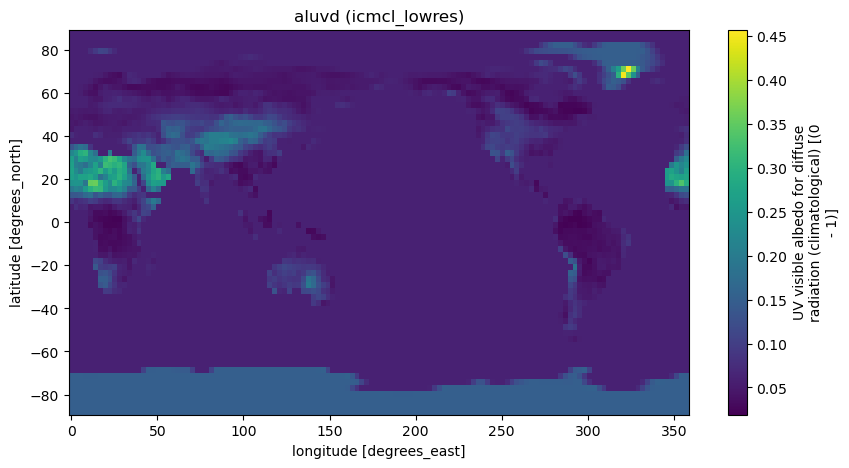

In [9]:
import matplotlib.pyplot as plt

# Escoge una variable representativa, por ejemplo la primera
var = list(icmcl_lowres.data_vars)[2]
print(f"Ploteando variable: {var}")

plt.figure(figsize=(10,5))
icmcl_lowres[var].isel(time=0).plot(cmap="viridis")  # si tiene dimensión "time"
plt.title(f"{var} (icmcl_lowres)")
plt.show()


In [10]:
# ===============================
# 3. Máscara de tierra
# ===============================
mask_tierra = landsea["landsea_mask"] == 1  # True en tierra

# Variables de albedo a modificar
albedo_vars = [var for var in icmcl_lowres.data_vars if "aluv" in var.lower() or "al" in var.lower()]

masked_vars = {}
for var in icmcl_lowres.data_vars:
    data = icmcl_lowres[var]
    if var in albedo_vars:
        masked_vars[var] = data.where(mask_tierra)  # océano = NaN
    else:
        masked_vars[var] = data

icmcl_masked = xr.Dataset(masked_vars)

Ploteando al enmascarada...


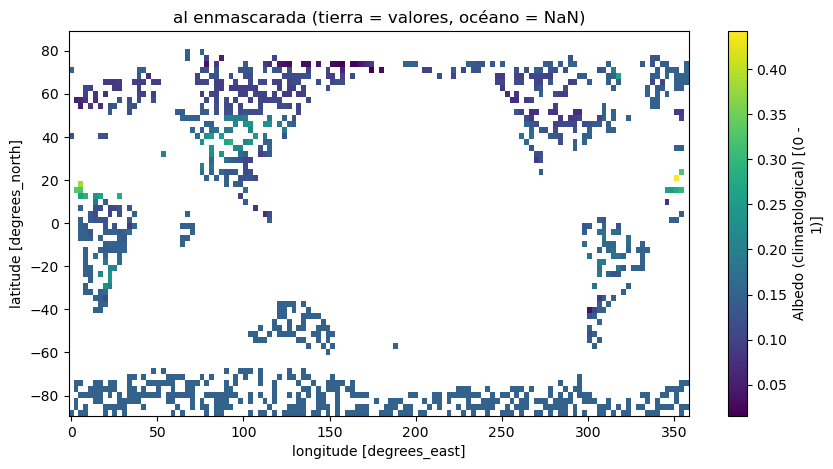

In [14]:
var = albedo_vars[0]
print(f"Ploteando {var} enmascarada...")

plt.figure(figsize=(10,5))
icmcl_masked[var].isel(time=0).plot(cmap="viridis")
plt.title(f"{var} enmascarada (tierra = valores, océano = NaN)")
plt.show()


In [6]:
# ===============================
# 4. Media zonal (solo sobre tierra)
# ===============================
zonal_mean = icmcl_masked.mean(dim="lon", skipna=True)

# ===============================
# 5. Reconstruir campo 2D
# ===============================
lat = icmcl_masked["lat"]
lon = icmcl_masked["lon"]

reconstructed = xr.Dataset()

for var in icmcl_masked.data_vars:
    if var not in zonal_mean:
        continue
    data = zonal_mean[var].expand_dims({"lon": lon})
    if data.ndim == 3:
        reconstructed[var] = data.transpose("time", "lat", "lon")
    elif data.ndim == 2:
        reconstructed[var] = data.transpose("lat", "lon")

In [23]:
# ===============================
# 5b. Copiar valores de 55S a Antártida
# ===============================

lat_ant = -70  # latitudes al sur de -60° = Antártida
lat_ref = -50  # referencia = sur de Sudamérica

ilat_ref = np.argmin(np.abs(lat.values - lat_ref))  # <<-- CORREGIDO

for var in albedo_vars:
    if var not in reconstructed:
        continue

    data = reconstructed[var].copy()

    if "time" in data.dims:
        ref_vals = data.sel(lat=lat[ilat_ref])
        mask_ant = lat < lat_ant
        data.loc[dict(lat=lat[mask_ant])] = ref_vals
    else:
        ref_vals = data.sel(lat=lat[ilat_ref])
        mask_ant = lat < lat_ant
        data.loc[dict(lat=lat[mask_ant])] = ref_vals

    reconstructed[var] = data



In [24]:
# ===============================
# 6. Rellenar océano con 0.5
# ===============================
for var in albedo_vars:
    data = reconstructed[var]
    if "time" in data.dims:
        data = data.where(mask_tierra.expand_dims({"time": data.sizes["time"]}), 0.5)
    else:
        data = data.where(mask_tierra, 0.5)
    reconstructed[var] = data

In [25]:
# ===============================
# 7. Guardar archivo final
# ===============================
reconstructed.to_netcdf(output_file)
print(f"✅ Archivo final guardado en: {output_file}")


✅ Archivo final guardado en: /lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_eoc_deepmip_v2.nc


In [16]:
albedo_vars

['aluvp', 'aluvd']

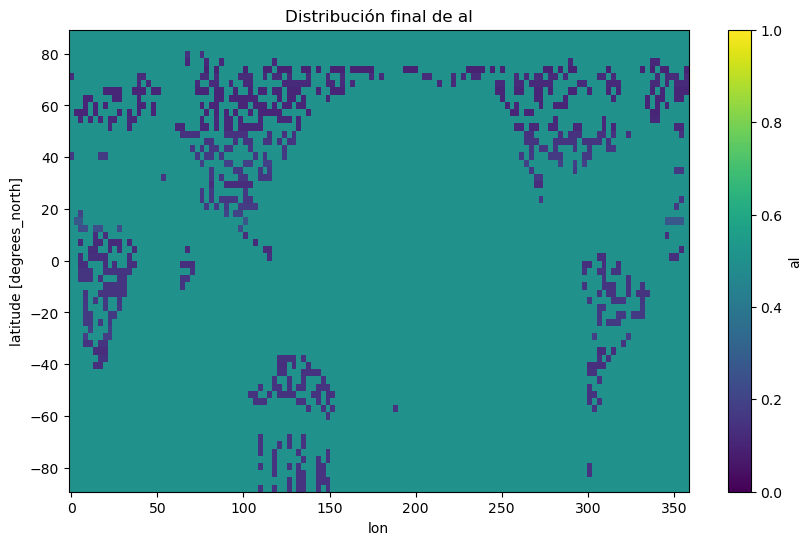

In [26]:
import matplotlib.pyplot as plt

# Elegimos una variable de albedo para chequear
var = albedo_vars[0]  # por ejemplo, la primera

# Si tiene dimensión temporal, agarro el primer paso de tiempo
if "time" in reconstructed[var].dims:
    data_plot = reconstructed[var].isel(time=0)
else:
    data_plot = reconstructed[var]

plt.figure(figsize=(10,6))
data_plot.plot.pcolormesh(
    x="lon", y="lat", cmap="viridis", vmin=0, vmax=1, add_colorbar=True
)
plt.title(f"Distribución final de {var}")
plt.show()

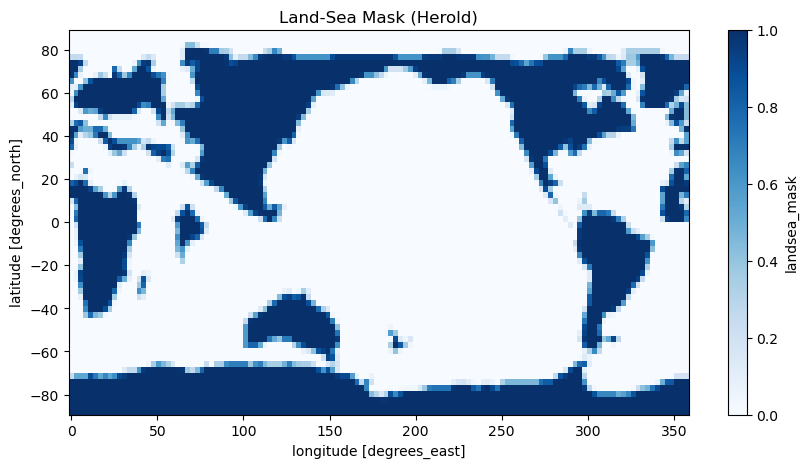

In [27]:
import matplotlib.pyplot as plt

# Extraer la variable de máscara
mask = landsea["landsea_mask"]

# Graficar
plt.figure(figsize=(10,5))
mask.plot(cmap="Blues")  # Blues = azul = oceano, valores 1 = tierra
plt.title("Land-Sea Mask (Herold)")
plt.show()

In [ ]:
# 8- Extraigo el landsea mask actual y elimino las dimensiones que no me sirven. Dejo solo lat y lon.
lsm = icmgg_remap["lsm"].isel(time=0).squeeze() 

# 9- Expando la landsea mask actual a las dimensiones del archivo icmcl_recap
lsm_exp = lsm.broadcast_like(icmcl_remap)  # ahora tiene (time=12, lat=96, lon=192)
# 10- Creo una mascara para land
land_mask = lsm_exp > 0.5 
# 11- Aplico la mascara de tierra al archivo icmcl
icmcl_masked = icmcl_remap.where(land_mask, np.nan)
# 12- Calculo media zonal y relleno NaNs en latitudes sin tierra
zonal_mean = icmcl_masked.mean(dim="lon", skipna=True)

# Reordenar para que lat vaya de sur (-90) a norte (+90). 
zonal_mean_sorted = zonal_mean.sortby("lat")

# Interpolar valores faltantes
zonal_mean_filled = zonal_mean_sorted.interpolate_na(dim="lat", method="nearest")

# (Si necesitas volver al orden original norte→sur). No se si este punto y el anteultimo son necesarios. Parece que giro las latitudes y despues las vuelvo a girar, pero no era necesario.
zonal_mean_filled = zonal_mean_filled.sortby("lat", ascending=False)

# 13- Reconstruyo 2D a partir de la media zonal 
lat = icmcl_masked["lat"] 
lon = icmcl_masked["lon"] 
reconstructed = xr.Dataset() 
for var in icmcl_masked.data_vars: 
    if var not in zonal_mean: 
        print(f"Variable {var} no está en el promedio zonal. Se omite.") 
        continue 
    print(f"Procesando: {var}") 
    data = zonal_mean[var].expand_dims({"lon": lon}) 
    
    if data.ndim == 3: 
        reconstructed[var] = data.transpose("time", "lat", "lon") 
    elif data.ndim == 2: 
        reconstructed[var] = data.transpose("lat", "lon") 

# 14- Creo mascaras para las bandas polares con albedos no glaciales
lat = reconstructed["lat"]
band_mask_s = (lat >= -52) & (lat <= -46)   # independiente de si lat está en orden N→S o S→N
band_mask_n = (lat >= 70) & (lat <= 75)   # independiente de si lat está en orden N→S o S→N

# 15- Aplico la mascara para 
# la banda norte
band_n = reconstructed.sel(lat=lat.where(band_mask_n, drop=True))

#la banda sur
band_s = reconstructed.sel(lat=lat.where(band_mask_s, drop=True))

# 16- Calculo el promedio espacial sobre lat y lon ---
# Resultado: Dataset con dims (time,) para cada variable, 
# Para la banda norte
mean_band_n = band_n.mean(dim=("lat", "lon"), skipna=True)

# Para la banda sur
mean_band_s = band_s.mean(dim=("lat", "lon"), skipna=True)

# 17- Creo una mascara para 
# las latitudes al sur de -52ºS 
south_mask = (lat < -52)
# las latitudes al norte de los 75ºN
north_mask = (lat > 75)

# 18- Relleno las latitudes australes con el promedio ---
# Broadcasting: (time,) -> se expande sobre lat y lon
mask_da_s = xr.DataArray(south_mask, dims=["lat"], coords={"lat": lat})
reconstructed_filled = reconstructed.where(~mask_da_s, other=mean_band_s)

# 19- Relleno las latitudes boreales con el promedio ---
# Broadcasting: (time,) -> se expande sobre lat y lon
mask_da_n = xr.DataArray(north_mask, dims=["lat"], coords={"lat": lat})
reconstructed_filled_n = reconstructed_filled.where(~mask_da_n, other=mean_band_n)

# 20- Reemplazo el dataset original 
icmcl_remap = reconstructed_filled_n

# 3- Cargo la ruta para la landsea mask del eoceno
eocene = EoceneOIFS(
    idir="/lus/h2resw01/hpcperm//ecme3497/ece4-database",
    odir="/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc",
    herold="/lus/h2resw01/hpcperm/ecme3497/herold-et-al-2014/Supp"
)

landsea_remap_path = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/landsea_eoc_remap.nc"


# 21- Guardar landsea_eoc como archivo temporal ---
landsea_eoc = xr.open_dataset(eocene.prepare_herold(flag="landsea_mask"))

with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
    landsea_path = tmp.name
    landsea_eoc.to_netcdf(landsea_path)

# 22- Definir archivo temporal de salida ---
with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
    landsea_remap_path = tmp.name


# 23- Remapear a la grilla N48 (96×192) ---
cdo.remapnn(
    f"N{gaussian}",   # archivo con la grilla target
    input=landsea_path, 
    output=landsea_remap_path,
    options="-f nc4"
)

# 24- Abrir resultado ---
landsea_on_icmcl = xr.open_dataset(landsea_remap_path)

# 25- Crear máscara booleana ---
mask_var_eoc = list(landsea_on_icmcl.data_vars)[0]   # debería ser "mask" o similar
lsm = landsea_on_icmcl[mask_var_eoc] > 0.5

# 26- Expandir máscara a dimensiones de icmcl_remap ---
mask_exp_eoc = lsm.broadcast_like(icmcl_remap)

# 27- Aplicar máscara a icmcl_remap ---
icmcl_masked_eoc = icmcl_remap.where(mask_exp_eoc, np.nan)

# 29- Recorremos las variables de albedo y reemplazamos NaN del océano por 0.05
icmcl_masked_eoc[albedo_vars] = icmcl_masked_eoc[albedo_vars].where(mask_exp_eoc, 0.05)
icmcl_masked_eoc[lai_vars] = icmcl_masked_eoc[lai_vars].where(mask_exp_eoc)